In [2]:
from functools import partial
import glob
import os
from typing import Callable, Optional, Sequence, Type

import equinox as eqx
from equinox import nn
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jaxtyping import Array, PRNGKeyArray
import optax

jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0.05)

from environment_base.util import load_compressed_pickle
from craftax.craftax_state import EnvState
from craftax.renderer import render_craftax_pixels
from craftax.constants import BLOCK_PIXEL_SIZE_AGENT, BLOCK_PIXEL_SIZE_IMG

%matplotlib inline

Loading textures from cache


In [3]:
run_paths = sorted(glob.glob(os.path.join('data/', '*.pbz2')))
run = load_compressed_pickle(run_paths[-1])

In [4]:
print(run.keys())
for k, v in run.items():
    print(f'{k}: {v.shape if isinstance(v, np.ndarray) else len(v)}')

dict_keys(['state', 'action', 'reward', 'done'])
state: 3645
action: 3644
reward: 3644
done: 3644


In [5]:
all_imgs = [render_craftax_pixels(state, BLOCK_PIXEL_SIZE_AGENT) for state in run['state']]
all_imgs = jnp.stack(all_imgs) / 255.0

all_actions = jnp.stack(run['action'])
all_rewards = jnp.stack(run['reward'])
all_dones = jnp.stack(run['done'])

(91, 77, 3)


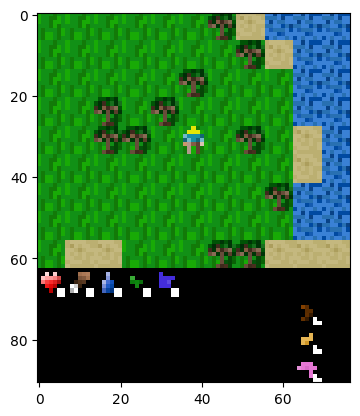

In [6]:
print(all_imgs[0].shape)
plt.imshow(all_imgs[0])
plt.show()

In [7]:
# TODO:
#   1. Create a function that trains the model to predict the next state with a variable batch size
#       - Make an MLP model
#       - Make an RMSProp optimizer
#       - Create a training loop
#   2. Test wth a few different batch sizes and step-sizes
#   3. Try adding FTA to a middle layer

In [ ]:
def make_mlp_layers(
    layer_sizes: Sequence[int],
    activation_cls: Optional[Type[eqx.Module]] = None,
    *,
    key: Optional[PRNGKeyArray] = None
) -> Array:
    layers = []
    if key is not None:
        keys = jax.random.split(key, len(layer_sizes) - 1)
    else:
        keys = [None] * (len(layer_sizes) - 1)
    
    for i in range(1, len(layer_sizes)):
        layers.append(
            nn.Linear(layer_sizes[i - 1], layer_sizes[i], use_bias=False, key=keys[i-1]))
        if i < len(layer_sizes) - 1 and activation_cls is not None:
            layers.append(activation_cls())
    return layers


class ReLU(eqx.Module):
    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        return jax.nn.relu(x)

model = nn.Sequential(make_mlp_layers(
    layer_sizes = [np.prod(all_imgs.shape[1:]), 16, np.prod(all_imgs.shape[1:])],
    activation_cls = ReLU,
    key = jax.random.PRNGKey(0),
))


class MLP(eqx.Module):
    layers: list[eqx.Module]
    activation: Optional[Callable[[Array], Array]] = eqx.field(static=True)

    def __init__(self, layer_sizes: Sequence[int], activation_fn: Optional[Callable[[Array], Array]] = None, *, key: Optional[PRNGKeyArray] = None):
        self.layers = make_mlp_layers(layer_sizes, key=key)
        self.activation = activation_fn

    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        for i, layer in enumerate(self.layers):
            x = layer(x, key=key)
            if self.activation is not None and i < len(self.layers) - 1:
                x = self.activation(x)
        return x

/tmp/ipykernel_71646/2272373058.py:15: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  nn.Linear(layer_sizes[i - 1], layer_sizes[i], use_bias=False, key=keys[i-1]))


In [9]:
obs_dim = 452 #int(np.prod(all_imgs.shape[1:]))
print('obs_dim', obs_dim)


mlp = MLP(
    layer_sizes = [obs_dim, 10, 5],
    activation_fn = jax.nn.relu,
    key = jax.random.PRNGKey(0),
)
print(jax.vmap(mlp)(jnp.ones((2, obs_dim,)), key=jax.random.PRNGKey(1)).shape)


model = nn.Sequential(make_mlp_layers(
    layer_sizes = [obs_dim, 16, obs_dim],
    activation_cls = ReLU,
    key = jax.random.PRNGKey(0),
))
print(model(jnp.ones((obs_dim,)), key=jax.random.PRNGKey(1)).shape)
print(jax.vmap(model)(jnp.ones((2, obs_dim))).shape)

obs_dim 452
(2, 5)
(452,)
(2, 452)


In [42]:
def loss_from_inputs_and_targets(model, batched_inputs, batched_targets):
    preds = jax.vmap(model)(batched_inputs, key=None)
    return jnp.mean((preds - batched_targets) ** 2)


def train_step(carry, inputs, optimizer: optax.GradientTransformation):
    model, opt_state, rng = carry
    inputs, targets = inputs
    rng, rng_step = jax.random.split(rng)
    
    loss, grads = jax.value_and_grad(loss_from_inputs_and_targets)(model, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    return (model, opt_state, rng), {
        'loss': loss,
    }


# @partial(jax.jit, static_argnames=('optimizer', 'batch_size',))
def train_loop(model, optimizer, opt_state, inputs, targets, batch_size, rng):
    n_batches = inputs.shape[0] // batch_size
    n_samples = n_batches * batch_size
    
    batched_inputs = inputs[:n_samples].reshape(n_batches, batch_size, -1)
    batched_targets = targets[:n_samples].reshape(n_batches, batch_size, -1)

    (model, opt_state, _), stats = jax.lax.scan(
        partial(train_step, optimizer=optimizer),
        init = (model, opt_state, rng),
        xs = (batched_inputs, batched_targets),
    )
    
    # stats = []
    # for i in range(n_batches):
    #     (model, opt_state, _), step_stats = train_step(
    #         (model, opt_state, rng),
    #         (batched_inputs[i], batched_targets[i]),
    #         optimizer,
    #     )
    #     stats.append(step_stats)
    
    return model, opt_state, stats

In [116]:
rng = jax.random.PRNGKey(20250901)
rngs = jax.random.split(rng, 10)

obs_dim = int(np.prod(all_imgs.shape[1:]))
model = nn.Sequential(make_mlp_layers(
    layer_sizes = [obs_dim, 64, 64, 64, obs_dim],
    activation_cls = ReLU,
    key = rngs[0],
))

n_params = sum(x.size for x in jax.tree_util.tree_leaves(model))
print(f"Total parameters: {n_params:,}")

learning_rate = 1.0 / np.sqrt(np.prod(all_imgs.shape[1:]))
optimizer = optax.rmsprop(learning_rate=learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

Total parameters: 2,698,880


0.10060621


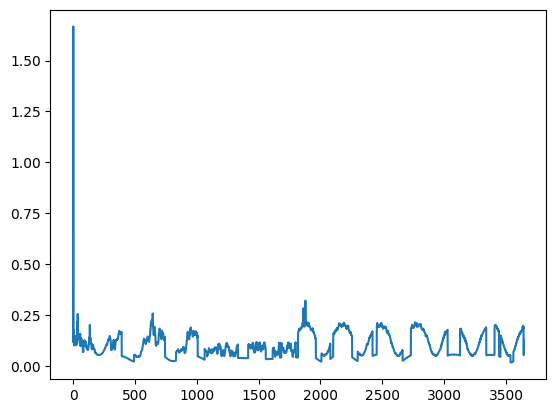

In [123]:
new_model, new_opt_state, stats = train_loop(
    model = model,
    optimizer = optimizer,
    opt_state = opt_state,
    inputs = all_imgs,
    targets = all_imgs,
    batch_size = 1,
    rng = rngs[1],
)

print(stats['loss'].mean())
plt.plot(stats['loss'])

In [69]:
jax.tree.reduce(lambda x, y: x and y, jax.tree.map(lambda x, y: (x == y).all(), model, new_model))

Array(False, dtype=bool)